In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
Ls = [20, 50, 100, 200]
bs = [1.651, 1.675, 1.701, 1.725, 1.749, 1.751, 1.775, 1.799, 1.801, 1.825, 1.851]
Nfields = 40
DROP = 5*10**2
CALC = 10**4
EVERY = 100

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 456, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .25 # probability of being assigned strategy C

In [4]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

In [4]:
%load_ext cython

In [9]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

# note the compile/link args

import numpy as np
cimport cython

from cython.parallel cimport prange     # prange

@cython.boundscheck(False)
@cython.cdivision(True)
def evolve2_3(long[:, ::1] field, float b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, iy, jx, jy, step, bestX, bestY
    
    L = field.shape[0]
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef long[:, ::1] current = np.zeros((L, L), dtype=int)
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
 
        with nogil:
            for x in prange(L):                # prange in a nogil section
                for y in range(L):             # only prange the outer loop
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            scores[x, y] += (1 - field[ix, jy])

                    if field[x, y] == 1:
                        scores[x, y] *= b

            for x in prange(L):                 # prange in a nogil section
                for y in range(L):
                    bestX = x
                    bestY = y
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            if (scores[bestX, bestY] < scores[ix, jy]):
                                bestX = ix
                                bestY = jy
                    field[x, y] = current[bestX, bestY]
    return np.asarray(field)

In [6]:
%%cython
import numpy as np
cimport cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve(long[:, :] field, double b, long num_epoch=1):
    cdef:
        int L = field.shape[0]
        int x, y, x1, x2, x3, y1, y2, y3, i, j, bestX, bestY
        long[:, :] next_state = np.zeros((L, L), dtype=int)
        double[:, :] scores = np.zeros((L, L), dtype=float)
        double[:, :] _zeros = np.zeros((L, L), dtype=float)
        
    assert L != 0
    
    next_state = field.copy()
    
    for _ in range(num_epoch):
        scores[...] = _zeros
        for x in range(L):
            for y in range(L):
                x1, x2, x3 = (x-1)%L, x%L, (x+1)%L
                y1, y2, y3 = (y-1)%L, y%L, (y+1)%L
                scores[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] + field[x2, y1] + field[x2, y2] + field[x2, y3] + field[x3, y1] + field[x3, y2] + field[x3, y3])
                if field[x, y] == 0:
                    scores[x, y] *= b
#         return scores
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if scores[(x+i)%L, (y+j)%L] > scores[bestX, bestY]:
                            bestX = (x+i)%L
                            bestY = (y+j)%L

                next_state[x, y] = field[bestX, bestY]
        
        field = next_state.copy()
        
    return np.asarray(field)

In [ ]:
field = 1-np.load("fields/field_500_4.npy")
d = []
for _ in tqdm(range(int(1000)), total=int(1000)):
    field = evolve2_3(field, 1.775, 1)
#             print(field.sum()/(1.*50^2))
    d.append(1 - field.sum()/(1.*field.shape[0]**2))

 16%|█▌        | 158/1000 [00:08<00:45, 18.61it/s]

In [ ]:
plt.plot(d)

In [6]:
density = []
for L in Ls:
    den = []
    for b in tqdm(bs):
        d = []
        for i in range(len(seeds)):
            field = np.load("fields/field_{}_{}.npy".format(L, i) )
            field = evolve(field, b, DROP)
            for _ in range(0, CALC-DROP, EVERY):
                field = evolve(field, b, EVERY)
                d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)

  0%|          | 0/11 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [7]:
density = []
for L in [200]:
    den = []
    for b in [1.650, 1.675, 1.749, 1.751, 1.799, 1.801, 1.851]:
        d = []
        for i in tqdm(range(len(seeds[:25])), total=len(seeds[:25])):
            field = np.load("fields/field_{}_{}.npy".format(L, i) )
            field = evolve(field, b, DROP)
            for _ in range(0, CALC-DROP, EVERY):
                field = evolve(field, b, EVERY)
                d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)

100%|██████████| 25/25 [34:29<00:00, 82.89s/it]


In [9]:
np.save("density_evol.npy", np.asarray(density))

In [11]:
density = np.asarray(density)

In [29]:
std = density.std(axis=2)
std2 = density2.std(axis=2)

In [30]:
means = density.mean(axis=2)
means2 = density2.mean(axis=2)

In [31]:
ste = std/np.sqrt(density.shape[-1])
ste2 = std2/np.sqrt(density2.shape[-1])

<IPython.core.display.Javascript object>


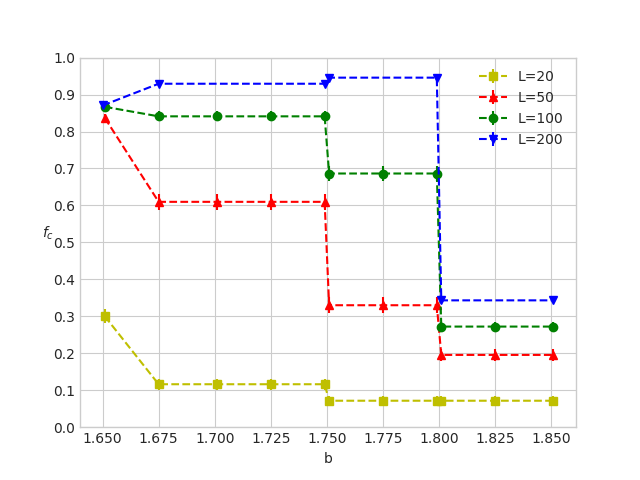

Text(0, 0.5, '$f_c$')

In [44]:
plt.errorbar(bs, means[0], yerr=3*ste[0], fmt="sy--", label="L=20")
plt.errorbar(bs, means[1], yerr=3*ste[1], fmt="^r--", label="L=50")
plt.errorbar(bs, means[2], yerr=3*ste[2], fmt="og--", label="L=100")
plt.errorbar([1.650, 1.675, 1.749, 1.751, 1.799, 1.801, 1.851], means2[0], yerr=3*ste2[0], fmt="vb--", label="L=200")
# plt.errorbar([1.7], [np.asarray(dex).mean()], fmt=">y", label="L=500")
plt.legend(loc="upper right")
plt.xlabel("b")
plt.yticks(np.arange(0., 1.1, .1))
plt.ylabel("$f_c$", rotation=0)